# CSCI4022 Homework 6; Directed Graphs


## Due Monday, October 25 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) |
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import scipy.stats as stats
# import statsmodels.api as sm

***
<a/ id='p1'></a>
[Back to top](#top)
# Problem 1 (Practice: PageRank; 25 pts)


The file `transfer_list.csv` contains a log of transfers of players between European footbal clubs.  Load it into memory and take a look at the columns.

Of particular importance to us are to think of the transfers of players as a **directed graph**, where the team purchasing the player in `Team_to` is spending money (in `Transfer_fee`) to gain the use of the player in each row.  If we were to run PageRank on this graph, it would give us a picture of which teams are importing the most talent!

In [2]:
df=pd.read_csv('transfer_list.csv')
df.head()

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


**Part A:** Process and explore the data.

The data should contain transfers to and from the 5 major European leagues: the Bundesliga in Germany, La Liga in Spain, Ligue 1 in France, Serie A in Italy, and the Premeir League in England.  Verify that these are the only leagues present in either the `League_from` or `League_to` columns.  If not, fix any descrepencies in the data or drop any rows involving other leagues.

You may use `re` or `string` methods if you desire.



In [3]:
print("Before Cleaning:")
print(df.League_from.unique())
print(df.League_to.unique())

# OCD removing the 1 from Bundesliga
df.loc[df.League_to == '1.Bundesliga', 'League_to']     = 'Bundesliga'
df.loc[df.League_from == '1.Bundesliga', 'League_from'] = 'Bundesliga'

# OCD changing LaLiga to La Liga 
df.loc[df.League_to == 'LaLiga', 'League_to']     = 'La Liga'
df.loc[df.League_from == 'LaLiga', 'League_from'] = 'La Liga'

# Adding accent to Serie A
df.loc[df.League_to == 'Serie A', 'League_to']     = 'Série A'
df.loc[df.League_from == 'Serie A', 'League_from'] = 'Série A'

print("After Cleaning:")
print(df.League_from.unique())
print(df.League_to.unique())

print(f'\nNumber of unique teams in Team_from: {len(df.Team_from.unique())}')
print(f'Number of unique teams in Team_to: {len(df.Team_to.unique())}')
print(f'Number of all unique teams: {len(set(df.Team_to).union(set(df.Team_from)))}')

Before Cleaning:
['LaLiga' 'Serie A' 'Premier League' 'Ligue 1' '1.Bundesliga' 'Série A']
['LaLiga' 'Serie A' 'Ligue 1' 'Premier League' '1.Bundesliga' 'Série A']
After Cleaning:
['La Liga' 'Série A' 'Premier League' 'Ligue 1' 'Bundesliga']
['La Liga' 'Série A' 'Ligue 1' 'Premier League' 'Bundesliga']

Number of unique teams in Team_from: 173
Number of unique teams in Team_to: 133
Number of all unique teams: 181


**Part B:** Create a (near) column-stochasitc transfer matrix where the presence of *any* transfer from team $A$ to $B$ is treated as the existence of an outlink from $A$ to $B$.  If a column is all-zeroes you can easy ensure it's column-stochastic via a constant or leave it as 0's.

Describe both the matrix's dimensions and sparsity: what proportion of its entries are 0?

In [4]:
all_teams       = list(set(df.Team_from).union(set(df.Team_to)))
n               = len(all_teams)
transfer_matrix = np.zeros((n,n))
for j, team in enumerate(all_teams):
    length = len(list(df.loc[df.Team_from==team].iterrows()))
    for row in df.loc[df.Team_from==team].iterrows():
        to_team = row[1].Team_to
        i = all_teams.index(to_team)
        transfer_matrix[i,j] = 1
for col in range(n):
    s = np.sum(transfer_matrix[:,col])
    if s != 0:
        transfer_matrix[:,col] /= s
# Checking each column sums to 1, it does
#     print(np.sum(transfer_matrix[:,col]))

# getting the number of zeros / total
total = 0
zeros = 0
for i in range(n):
    for j in range(n):
        total += 1
        if transfer_matrix[i, j] == 0:
            zeros += 1
print(f'The matrix is {n} X {n}\nThere are {zeros} zeros out of {total} total entries: {(zeros/total) * 100}%')

The matrix is 181 X 181
There are 31273 zeros out of 32761 total entries: 95.45801410213363%


---

As seen in my little test above, the dimensions of the matrix are $181$x$181$, and roughly $95$% of entries are zeros. Very sparse matrix...

---

**Part C:** Make a transfer dictionary or list, since the matrix is pretty sparse!  Follow the general conventions used in the in-class notebooks for **sparse** page rank.  You may use integer keys or team names, but I suggest integers for ease of use.

In [5]:
# I honestly didn't really know how to turn the teams into integer keys
transfer_dictionary = {team: [] for team in df.Team_from.unique()}
for index, row in df.iterrows():
    transfer_dictionary[row.Team_from].append(row.Team_to)
print(transfer_dictionary['Chelsea'])

['Sunderland', 'Valencia CF', 'Fulham', 'Spurs', 'Leicester', 'AC Milan', 'Birmingham', 'Olympique Lyon', 'Atlético Madrid', 'Newcastle', 'Birmingham', 'Newcastle', 'FC Barcelona', 'Middlesbrough', 'Valencia CF', 'West Ham', 'Real Madrid', 'Portsmouth', 'Man City', 'Man City', 'Man City', 'Aston Villa', 'VfB Stuttgart', 'Real Madrid', 'Paris SG', 'Liverpool', 'Man Utd', 'VfL Wolfsburg', 'Paris SG', 'Everton', 'VfL Wolfsburg', 'Southampton', 'Atlético Madrid', 'Arsenal', "Bor. M'gladbach", 'Southampton', 'Sevilla FC', 'AS Roma', 'Sunderland', 'Middlesbrough', 'Atlético Madrid', 'Man Utd', 'Bournemouth', 'Juventus', 'Bournemouth', 'Olympique Lyon', 'Newcastle']


**Part D:** Run sparse PageRank using your object in **c**.  Report the top 20 clubs for receiving transfers by their PageRanks.  Use a teleportation probability of $1-\beta=0.2$.

After that, take a look at the 2000-2018 finals of the UEFA Champions League (UCL), [here](https://en.wikipedia.org/wiki/List_of_European_Cup_and_UEFA_Champions_League_finals).  Does it appear that receiving lots of transfers is helping with being competitive in the largest of European competitions?

In [6]:
def dist_L1(x,y):
    return np.sum(np.abs(np.array(x)-np.array(y)))

def dist_L2(x,y):
    return np.sqrt(np.sum((x-y)**2))

def chebyshev_d(x,y):
    return np.max(np.abs(x-y))

def get_all_links(Compact_Matrix):
    s = set(Compact_Matrix.keys())
    for value in Compact_Matrix.values():
        for item in value:
            s.add(item)
    return list(s)

def rank_links(links, ranks):
    l = list()
    for i, link in enumerate(links):
        l.append((link, ranks[i]))
    return sorted(l, key=lambda x: x[1], reverse=True)

def sparse_pagerank(Compact_Matrix):
    BETA       = 0.8
    all_links  = get_all_links(Compact_Matrix)
    n          = len(all_links)
    r_old      = np.repeat(1/n, n)
    tolerance  = 10e-6
    converged  = False
    iterations = 0
    while not converged:
        r_new = np.repeat((1-BETA)/n, n)
        # distribute importance payments between the nodes
        for link, outlinks in Compact_Matrix.items():
            d_i = len(outlinks)
            for outlink in outlinks:
                j         = all_links.index(outlink)
                i         = all_links.index(link)
                r_new[j] += ((BETA * r_old[i]) / d_i)
        r_new /= np.sum(r_new)
        if dist_L2(r_new, r_old) <= tolerance:
            converged = True
        r_old  = r_new.copy()
        iterations += 1
    r = rank_links(all_links, r_new)
    return r, iterations

r, i = sparse_pagerank(transfer_dictionary)
print(f'Top 20 teams ranks:\n{r[:20]}')
print(f'Number of iterations: {i}')

Top 20 teams ranks:
[('Chelsea', 0.030924681326767397), ('Man City', 0.03056637863064999), ('Liverpool', 0.02906258233236286), ('Everton', 0.02495856321381659), ('Juventus', 0.023999597812688483), ('Spurs', 0.0232024394852601), ('Inter', 0.02241447951518268), ('Real Madrid', 0.02091050337679378), ('AC Milan', 0.02027655594043049), ('Atlético Madrid', 0.019299384774525124), ('Aston Villa', 0.019055827618899374), ('FC Barcelona', 0.01876800988031702), ('AS Roma', 0.01822945055003085), ('West Ham', 0.017511970296223433), ('Man Utd', 0.017376731907623646), ('Bayern Munich ', 0.017097767710974463), ('Paris SG', 0.016816238279687864), ('Sunderland', 0.016813231167112506), ('Newcastle', 0.01575645671521464), ('Arsenal', 0.014151474441872676)]
Number of iterations: 13


---

So after looking at the top 20 teams determined by my page rank, and then looking at the list of UCL finals, it's quite clear that receiving lots of transfers is quite helpful. The only team that won the championship that wasn't on our top 20 list was from a league we didn't even have in our dataset. Further, a large majority of the runner-ups was also on our list. Although our second ranked club, Manchester City, never played in the championship during this period which is interesting, it's completely possible they should simply hire Ted Lasso to help coach all of that talent.

**Aside:** I wonder if my final pagerank looks like the true solution... Although I'm fairly confident in my implementation because of the top 20, it's at this point I hope I didn't mess something small up that put these teams in this order.

---

**Part E:** Try *weighted* page rank on this problem.  In *weighted* page rank, each edge of the matrix or link out from node $i$ is represented by a numerical value that may not be $1/d_i$; rather you could "move" to some destinations more often.  This may be because some links occur multiple times, or simply command a greater bandwidth or flow of traffic.  We could in this problem weight each transfer by the dollars involved!

Create a column-stochastic matrix where each entry is the proportion of  `Transfer_fee` dollars sold by that team (in the column).  A team $i$ with outgoing transfers of \$5 to team $a$ and a transfer of \$10 to team $b$ would have a (1/3) and a (2/3) in those two rows of column $i$, for example.

Now re-run pagerank, this time using the standard `matmul` approach on the column-stochastic (where possible) *weighted* matrix $M$ instead of a sparse implementation.  Again use a teleportation probability of $1-\beta=0.2$.

Who are the biggest buyers?  Does it correlate better with UCL success?

In [7]:
weighted_transfer_matrix = np.zeros((n,n))
for j, team in enumerate(all_teams):
    length = len(list(df.loc[df.Team_from==team].iterrows()))
    for row in df.loc[df.Team_from==team].iterrows():
        to_team      = row[1].Team_to
        transfer_fee = row[1].Transfer_fee
        i = all_teams.index(to_team)
        weighted_transfer_matrix[i,j] = transfer_fee
for col in range(n):
    s = np.sum(weighted_transfer_matrix[:,col])
    if s != 0:
        weighted_transfer_matrix[:,col] /= s
# Checking each column sums to 1, it does
#     print(np.sum(transfer_matrix[:,col]))

In [8]:
def PageRank(M, indices_to_names):
    n     = M.shape[0]
    BETA  = 0.8
    Nmat  = np.ones((n,n))/n
    A1    = BETA*M + (1-BETA)*Nmat
    r_old = np.repeat(1/n, n)
    r_new = np.ones(n)

    tolerance = 10e-6
    iters     = 0
    converged = False
    while not converged:
        r_new = np.matmul(A1, r_old)
        if dist_L2(r_new, r_old) <= tolerance: 
            converged = True
        r_old = r_new.copy()
        iters += 1

    r = rank_links(indices_to_names, r_new)
    
    return r, iters

r, i = PageRank(weighted_transfer_matrix, all_teams)
print(f'Top 20 teams ranks:\n{r[:20]}')
print(f'Number of iterations: {i}')

Top 20 teams ranks:
[('Man Utd', 0.0002076866507407992), ('Chelsea', 0.00020502569021281275), ('Man City', 0.0001961611775979591), ('Liverpool', 0.00019337254192696254), ('Real Madrid', 0.00019027441437171927), ('Paris SG', 0.00018013615307274923), ('Juventus', 0.00016401471671408481), ('FC Barcelona', 0.0001385948525096136), ('Everton', 0.00012735327429355518), ('Arsenal', 0.00010523144021149467), ('Atlético Madrid', 0.0001007790735833972), ('Spurs', 9.964961143402679e-05), ('Inter', 8.349819531691041e-05), ('AS Roma', 8.196416986416449e-05), ('Bayern Munich ', 7.861176489615878e-05), ('West Ham', 7.700848856842986e-05), ('AC Milan', 7.370425813027789e-05), ('Aston Villa', 6.69349231109337e-05), ('Monaco', 6.549841204536699e-05), ('VfL Wolfsburg', 6.307200370550553e-05)]
Number of iterations: 352


---

**THIS IS WRONG!!!**
**I was accidentally swapping the indices of i and j when creating my matrices!**
While we still see some big names on this list like Juventus, Real Madrid, FC Barcelona, and Liverpool to name a few, we see many other names that didn't even make the championship. Compared to when we ran sparse pagerank, we see many more teams on *this* biggest buyers list that weren't in the sparse pagerank list. For example, Olympique Lyon was #1 on the biggest buyers list here, yet they never made it to the championship. This is the case with more teams on this list than the other one. So I'd conclude that being the biggest buyer of other players may not be indicative of overall success in the UCL. Unless you're Real Madrid... They seem like an absolute powerhouse.

**CORRECT ANSWER!**
YES! The top-10 (out of the top-20) were all relatively high performers in the UCL. Real Madrid jumped up on this list compared to the sparse pagerank list, and our new #1, Manchester United did pretty well in the UCL during this period. We still have some teams that didn't do *that* well in the bottom half of our 20, but at least I recognize all of these names with the exception of VFL Wolfsburg. I'd say this might be a better list than the other list.

---


***
<a/ id='p2'></a>
[Back to top](#top)
# Problem 2 (Theory and Practice: Directed Graphs; 20 pts) 

Suppose our graph is a chain of $n$ nodes, as shown below.  

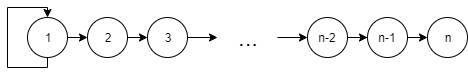

#### a) Set up a small experiment where you implement Hubs and Authorities on a graph of this form for a *specific* value of $n$, such as $n=6$.  Run the algorithm the "max-element equals 1" normalization, and use a convergence check using the max-norm ($L_\infty$) and a tolerance of $10^{-6}$.  Print the final Hubs and Authorities scores and how many iterations were run until convergence.

In [9]:
# generates the matrix L for a graph of the form shown above
def generate_L(n):
    L = np.zeros((n, n))
    for i in range(n-1):
        if i == 0:
            L[0,0]   = 1
            L[0,1]   = 1
        else:
            L[i,i+1] = 1
    return L

n = 6
L = generate_L(n)
print(L)

[[1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]


In [10]:
def HITS(L):
    LT = L.T
    n  = L.shape[0]
    a  = np.ones(n)
    h  = np.ones(n)
    
    convergence = False
    tolerance   = 10e-6
    iterations  = 0
    while not convergence:
        a_old = a
        h_old = h
        
        a     = np.matmul(LT, h)
        a    /= np.max(a)
        
        h     = np.matmul(L, a)
        h    /= np.max(h)
        
        iterations += 1
        max_change  = np.max([chebyshev_d(h,h_old), chebyshev_d(a,a_old)])
        if  max_change <= tolerance:
            convergence = True
            
    return a, h, iterations

def chebyshev_d(x,y):
    return np.max(np.abs(x-y))

authorities, hubs, iters = HITS(L)
print(f'Authority Scores:\n{authorities}')
print(f'Hub Scores:\n{hubs}')
print(f'Number of iterations: {iters}')

Authority Scores:
[1.00000000e+00 1.00000000e+00 7.62939453e-06 7.62939453e-06
 7.62939453e-06 7.62939453e-06]
Hub Scores:
[1.00000000e+00 3.81469727e-06 3.81469727e-06 3.81469727e-06
 3.81469727e-06 0.00000000e+00]
Number of iterations: 18


#### b) Set up the system of equations that represent taking one step of the HITS algorithm.  In other words, use markdown to explicitly state what $A^{new}$ will be as a function of $H^{old}$, and $H^{new}$ as a function of $A^{old}$.   I suggest you use your code from a) to check your work!

$A^{new}=L^{T}H^{old}$

$H^{new}=LA^{old}$

---

I'm *pretty* sure what I have is correct, and it matches what I've done in code for a). Although, the purely theoretical nature of this question gives me some doubt.

#### c) What will be the exact values of $A^{new}_j$ and $H^{new}_j$ resulting from the $j$th pass through the HITS algorithm, after normalization?

1.

$A^{new}_j = L^{T}H_{j-1}$

$H^{new}_j = LA_{j-1}$

---

Again, *pretty* sure I'm correct. Although, this seems almost too simple an answer because it is the same answer I've put above with different notation. I suppose we could say something like this (?):

---
2.

$A^{new}_j = j \cdot L^{T}H$

$H^{new}_j = j \cdot LA$

#### d) Your code in a) should have converged to the thereotical result from taking the *limit* (after many iterations) of the argument you constructed in c).  *Exactly* how many steps did it take until you converged?  Is this consistent with the theoretical result in part b?

---

My code converged in 18 steps.

Still pretty confused to be honest. I get that this is eigen-stuff, but I'm not really sure how to answer this. The first argument I've constructed in c) is quite literally what my code reproduces, and I'm a little confused how to take the limit of it. Further, I'm not really sure if this is consistent with my answer to b), but I think the stepsto convergence rely more heavily on the tolerance I've defined in HITS.

---